# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#Using a custom datadir, because my jupyter notebook runs with a home dire mounted a NFS mount point
data_dir = '/data/datadir/dlnd-facegeneration-data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [2]:
import matplotlib as mpl
print(mpl.get_cachedir())

/home/lgrazioli/.cache/matplotlib


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

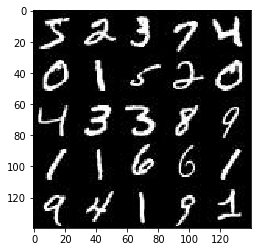

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

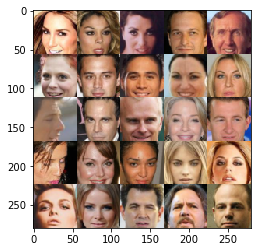

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 56, 56, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #Real input shape: (batch_size, width, height, channels)
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    #z input shape: (batch_size, z_dim)
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Discriminator take as input 28x28xnum_channels
        #Shouldn't use batch normalization in the first discriminator conv layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Leaky RELU
        conv1 =  tf.maximum(alpha * conv1, conv1)
        #Implement dropout with low drop_rate, discriminator only used in training, dropout always present
        conv1 = tf.nn.dropout(conv1, keep_prob=0.7)
        
        #14x14x64
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob=0.7)
        
        #7x7x128
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        conv3 = tf.nn.dropout(conv3, keep_prob=0.7,)
        
        #7x7*256
        #Flatten layer
        flat = tf.reshape(conv3, (-1, 7*7*256))
        #Logits and output
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #(not is_train): if it's train do not reuse variable if it's not reuse them
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Fully connect and z connection to transpose conv pyramid
        #Land in 7x7x256
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #Batch norm and LRELU
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        
        #Transpose convolution
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #Dropout only if it's train
        if is_train:
            x2 = tf.nn.dropout(x2, keep_prob=0.7)
        #Now (14,14,256)
        
        #Transpose convolution
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x3= tf.layers.batch_normalization(x3, training=is_train)
        x3= tf.maximum(alpha * x3, x3)
        if is_train:
            x3 = tf.nn.dropout(x3, keep_prob=0.7)
        #Now (28,28,128)
        
        #Transpose convolution
        #Already in 28x28, strides must be 1
        x4 = tf.layers.conv2d_transpose(x3, 56, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x4= tf.layers.batch_normalization(x4, training=is_train)
        x4= tf.maximum(alpha * x4, x4)
        if is_train:
            x4 = tf.nn.dropout(x4, keep_prob=0.7)
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label smoothing
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        #Run g_train_opt twice
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    #data_shape[1:] beacuse model inputs doesn't expect batch size as input
    input_real, input_z, learn_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    if data_image_mode == 'L':
        out_channels_dim = 1
    else:
        out_channels_dim = 3
    d_loss, g_loss = model_loss(input_real, input_z, out_channels_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                #Normalize input
                batch_images = batch_images * 2
                #Generate random unifrom z vector
                batch_z = np.random.uniform(-1 , 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate_tensor: learning_rate})
                
                #Print stats
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, out_channels_dim, data_image_mode)
        saver.save(sess, './generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0355... Generator Loss: 1.3762
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 1.4066
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.9151


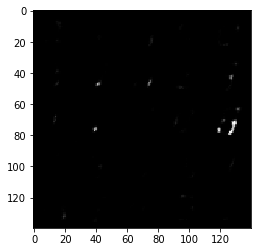

Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 1.1027
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 1.3921
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 1.2794


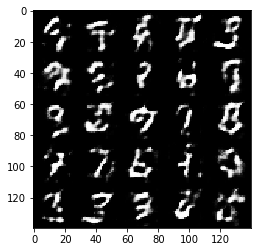

Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 1.7019... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 1.4819


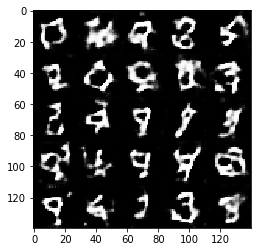

Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 1.1046


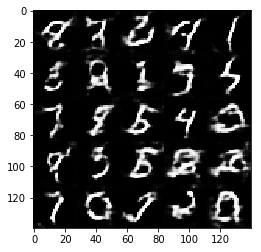

Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 1.2836
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.1496
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.6067


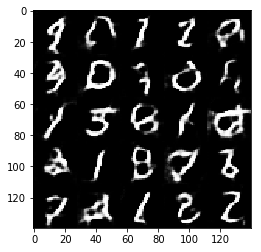

Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 1.1013
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.6904


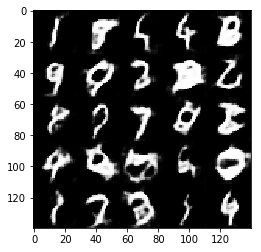

Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 1.3189
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 1.0380
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.9923


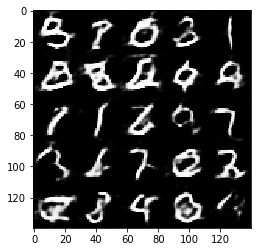

Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.4501
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 1.3838
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 1.2690


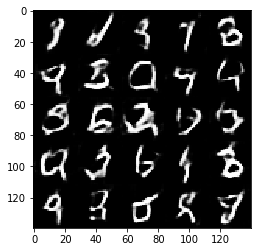

Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.9899


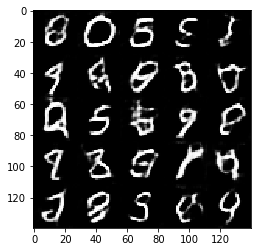

Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.3899


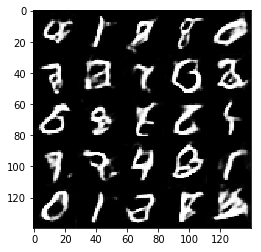

Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.5301
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.9975


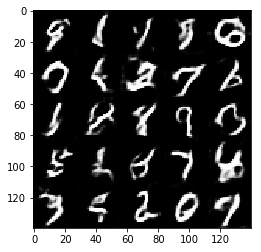

Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.2361
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 1.3139


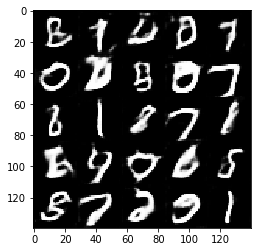

Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.6132
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 1.1029


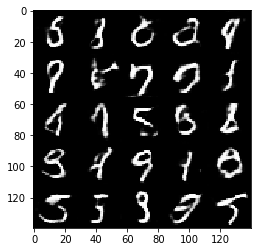

Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 1.1131


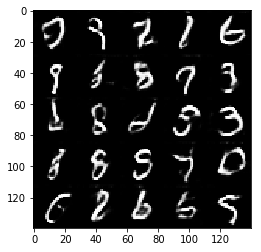

Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 1.1123


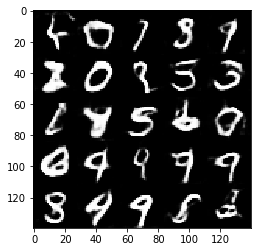

Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.8753
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.8710


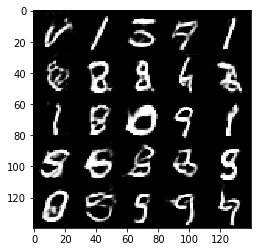

Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 1.5121
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 1.1056


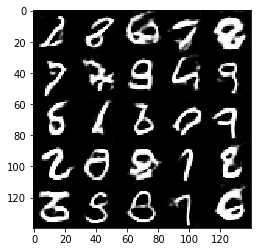

Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 1.4050
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.6082... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.7606


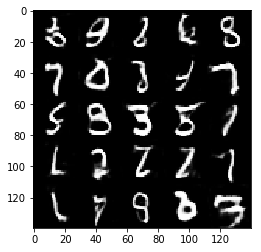

Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 1.4130


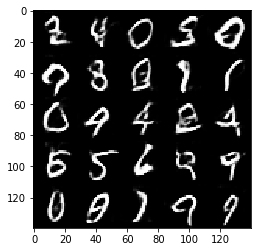

Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 1.0259
Epoch 2/2... Discriminator Loss: 1.5972... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.1368


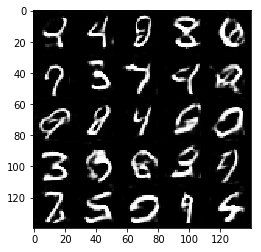

Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.8486


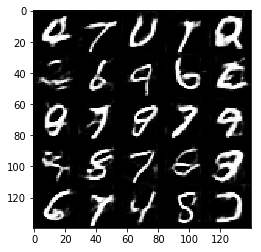

Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 1.6432... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.1132


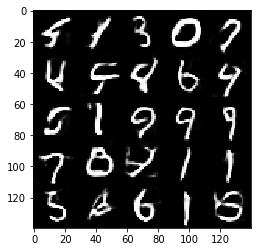

Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.6625


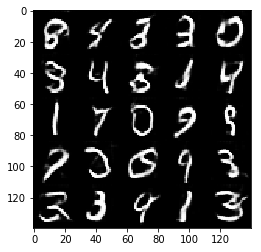

Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.8146


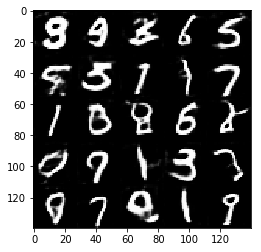

Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.2463
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 1.0941


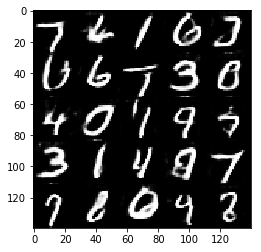

In [13]:
batch_size = 24
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 2.7360
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 3.2021
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 4.4756


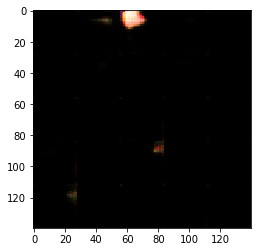

Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 2.5725
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.9901
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 3.2804
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 2.4848


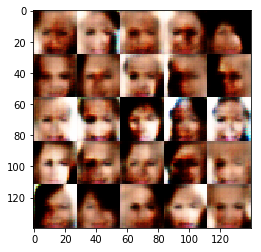

Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 2.1212
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 2.8958
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 2.4224


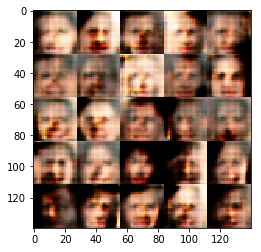

Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.4293


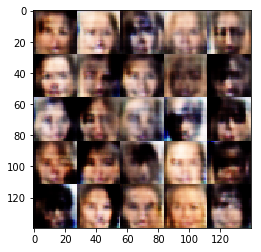

Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.5542


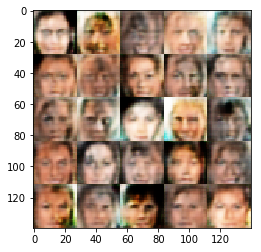

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.4021


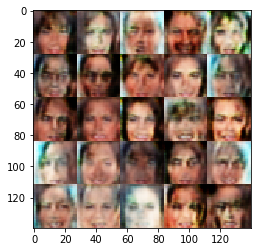

Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.1687


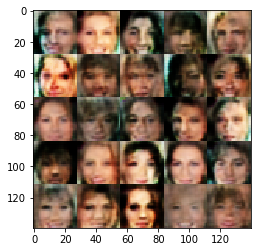

Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.9178


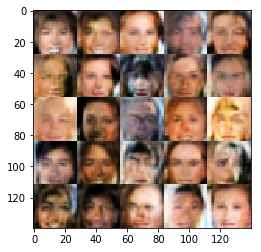

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.9730


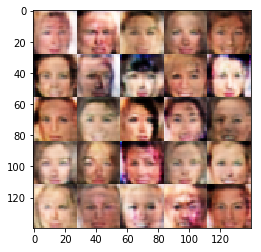

Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9489


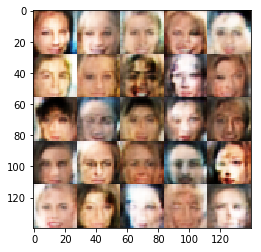

Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9931


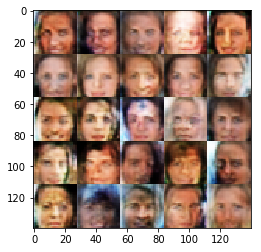

Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7332


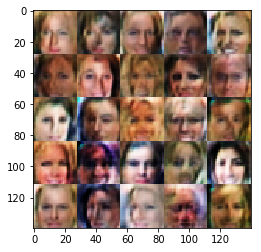

Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.9944


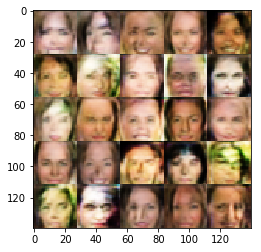

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.9558


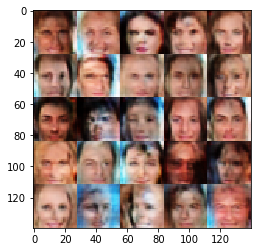

Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8575


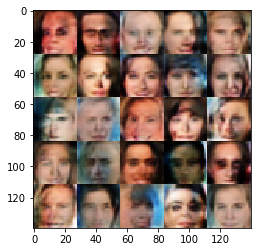

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7654


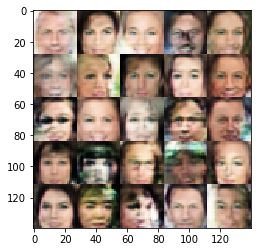

Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7563


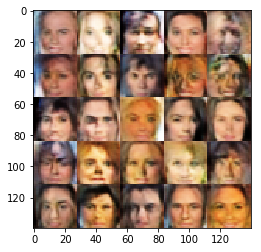

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.9122


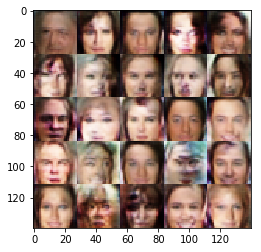

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8593


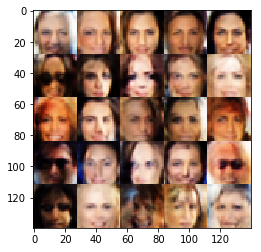

Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8813


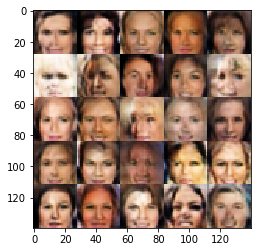

Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.9004


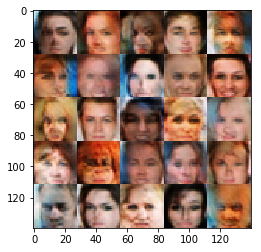

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9400


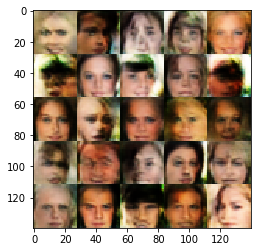

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.0283


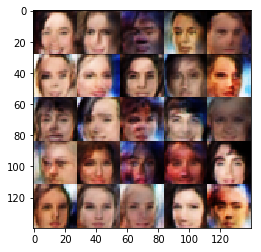

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8861


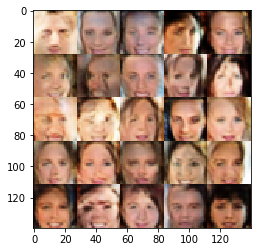

Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.9084


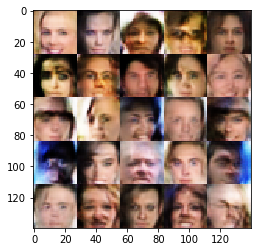

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.9416


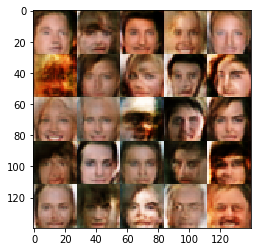

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8502


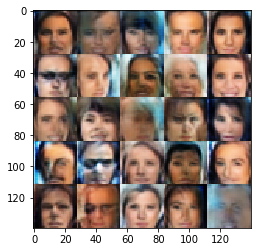

Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7897


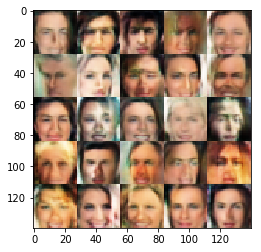

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8054


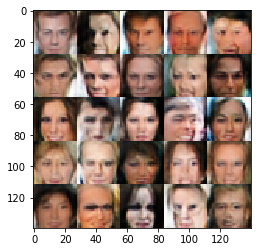

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7263


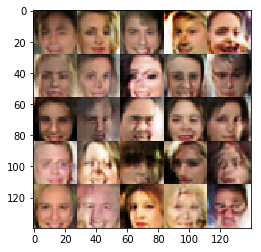

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8050


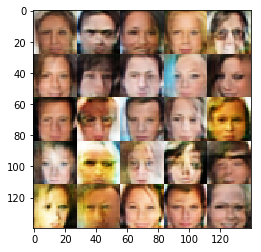

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8659


In [14]:
z_dim = 100
learning_rate = 0.0002
batch_size = 32
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.